In [1]:
%load_ext autoreload
%autoreload 2

import os
import json
import copy
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import ray_results_interpreter as rri
import subprocess
import concurrent.futures
from main_run import MainRun

/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/user/ml4723/.conda/envs/neural_inventory_control/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    2                GNN            32768    2.793740  2.791823   3.062970   10.649382
0                    2         Vanilla NN            32768    2.768540  2.766959   2.768177    0.000000
1                    5         Vanilla NN            32768    4.302981  4.302325   4.334030    0.000000
2                    8         Vanilla NN            32768    5.193800  5.193281   5.192908    0.000000
3                   11         Vanilla NN            32768    5.800327  5.803606   5.802871    0.000000


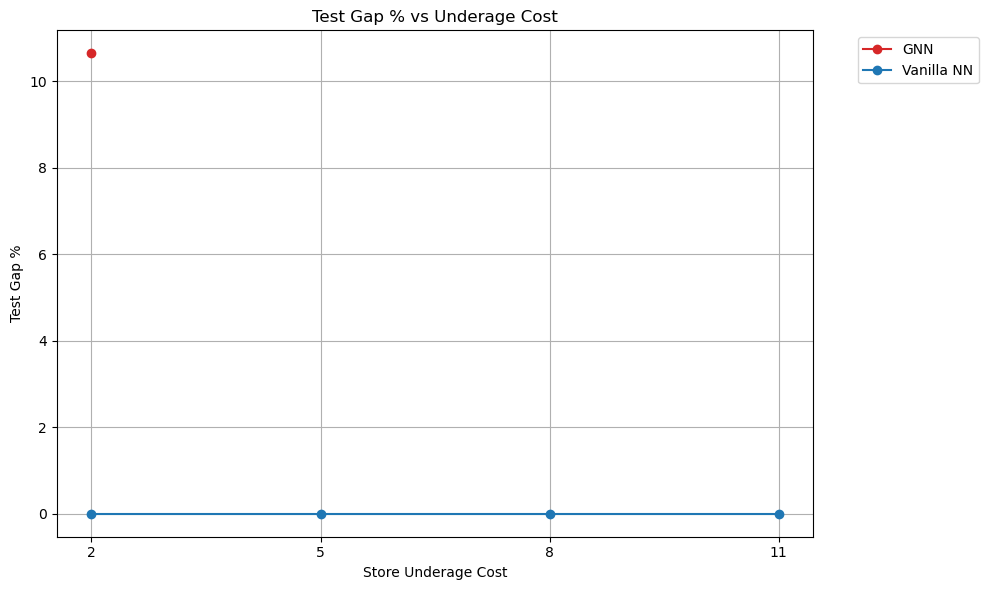

In [6]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "Vanilla NN": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "GNN": "-",
    "Vanilla NN": "-",
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [2, 5, 8, 11]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 32768},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# Combine dataframes
df = pd.concat([
    df_gnn, df_vanilla
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()  

One warehouse n stores real data(46 stores, 109 samples)
   store_underage_cost Architecture Class  train_n_samples  Train Loss  Dev Loss  Test Loss  Test Gap %
0                    2                GNN               16    2.871276  2.918405   2.875786    0.000000
0                    2         Vanilla NN               16    2.905312  3.183532   3.185325   10.763643
1                    5                GNN               16    4.350075  4.553053   4.687140    0.000000
1                    5         Vanilla NN               16    4.691977  5.186448   5.299352   13.061535
2                    8                GNN               16    5.381351  5.420049   5.750407    0.000000
2                    8         Vanilla NN               16    5.657253  6.509572   6.638031   15.435848
3                   11         Vanilla NN               16    6.426747  7.273920   7.539107    0.000000


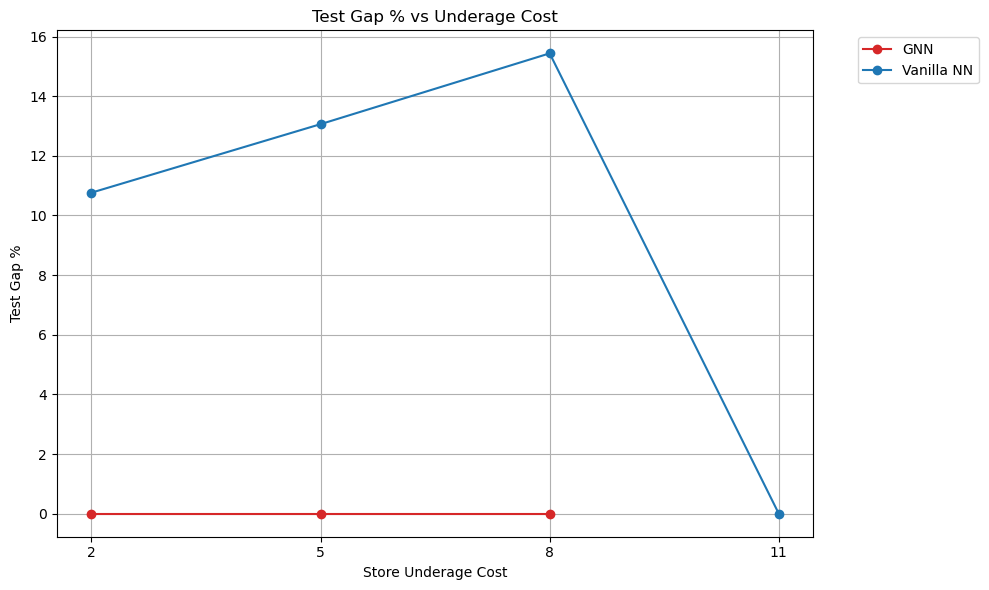

In [7]:
# Define color scheme for architecture types
color_scheme = {
    "GNN": "#d62728",  # red
    "Vanilla NN": "#1f77b4",  # Blue
}

linestyle_scheme = {
    "GNN": "-",
    "Vanilla NN": "-",
}

path = 'generic_architecture_n_warehouse'
gnn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/GNN',
}
vanilla_nn_paths = {
    10: f'/user/ml4723/Prj/NIC/ray_results/{path}/vanilla_n_warehouses',
}
def custom_data_filler(out_row, reference_row):
    out_row['path'] = reference_row['path']

def default_condition_setter(condition_name):
    return None

sort_by = 'dev_loss'
pick_row_from_run_by = 'dev_loss'
store_underage_cost = [2, 5, 8, 11]
results_interpretor = rri.RayResultsinterpreter()

# GNN
df_gnn = results_interpretor.make_table(gnn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_gnn.insert(1, 'Architecture Class', "GNN")
df_gnn.insert(1, 'hyperparam_name', "GNN")

# Vanilla NN
df_vanilla = results_interpretor.make_table(vanilla_nn_paths,
    {'store_underage_cost': store_underage_cost, 'train_n_samples': 16},
    default_condition_setter, custom_data_filler, sort_by=sort_by, pick_row_from_run_by=pick_row_from_run_by)
df_vanilla.insert(1, 'Architecture Class', "Vanilla NN")
df_vanilla.insert(1, 'hyperparam_name', "vanilla_n_warehouses")

# Combine dataframes
df = pd.concat([
    df_gnn, df_vanilla
])

min_test_loss = df.groupby(['store_underage_cost'])['Test Loss'].transform('min')
df['Test Gap %'] = ((df['Test Loss'] - min_test_loss) / min_test_loss) * 100
df.insert(df.columns.get_loc(df.columns[-2]), 'Test Gap %', df.pop('Test Gap %'))
df.drop(columns=['# of stores'], inplace=True)
df.sort_values(by=['store_underage_cost', 'Architecture Class'], inplace=True)
cols = df.columns.tolist()
cols.remove('store_underage_cost')
cols = ['store_underage_cost'] + cols
df = df[cols]

df_to_print = df.copy()
df_to_print.drop(columns=['hyperparam_name', 'Learning Rate', 'path', '# of runs'], inplace=True)
print("One warehouse n stores real data(46 stores, 109 samples)")
print(df_to_print.to_string())

# Create plot for Test Gap % vs Underage Cost
fig, ax = plt.subplots(figsize=(10, 6))

# Plot for Test Gap % - take best performing one (highest Test Gap %) for each group
pivot_df = df.groupby(['store_underage_cost', 'Architecture Class'])['Test Gap %'].min().unstack()

for column in pivot_df.columns:
    ax.plot(pivot_df.index.to_numpy(), pivot_df[column].to_numpy(),
            marker='o',
            label=column,
            color=color_scheme[column],
            linestyle=linestyle_scheme[column])

ax.set_xlabel('Store Underage Cost')
ax.set_ylabel('Test Gap %')
ax.set_title('Test Gap % vs Underage Cost')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True)
ax.set_xticks(pivot_df.index)

plt.tight_layout()
plt.show()  